<a href="https://colab.research.google.com/github/suhaib2421/Machine-Learning-GRACC-Outlier-Detection/blob/master/ML_GRACC_Outlier_Detection_Suhaib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
# All the imports/libraries needed 
!pip install -U -q elasticsearch elasticsearch_dsl numpy scipy sklearn
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import matplotlib.font_manager
import elasticsearch
from elasticsearch_dsl import Search, Q, A
import urllib3
import math
import datetime
import sklearn
from pandas.io.json import json_normalize

# Get rid of insecure warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [60]:
es = elasticsearch.Elasticsearch(
        ['https://gracc.opensciencegrid.org/q'],
        timeout=300, use_ssl=True, verify_certs=False)

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/http_urllib3.py:193: UserWarning: Connecting to https://gracc.opensciencegrid.org:443 using SSL with verify_certs=False is insecure.
  % self.host


In [81]:
def metrics():

  osg_summary_index = 'gracc.osg.summary'
  s = Search(using=es, index=osg_summary_index)
  
  end_time = datetime.datetime.now()   # The end time is today
  start_time = end_time - datetime.timedelta(days=365)   # Start day is a year ago from today
  
  s = s.query('bool',
          filter=[
              Q('range', EndTime={'gt': start_time, 'lt': end_time })
            & Q('term', ResourceType='Batch')
          ]
      )

  a = A("terms", field="SiteName", size=(2**31)-1)  
  b = A("terms", field="VOName", size=(2**31)-1) 
  curBucket = s.aggs.bucket("probe_terms", a)
  curBucket = curBucket.bucket("vonames", b)
  curBucket = curBucket.bucket("EndTime", 'date_histogram', field="EndTime", interval="7d")

  bkt = curBucket
  bkt = bkt.metric('WallDuration',       'sum', field='WallDuration', missing = 0)
  bkt = bkt.metric('NumberOfJobs',       'sum', field='Count', missing = 0)
  bkt = bkt.metric('EarliestEndTime',    'min', field='EndTime')
  bkt = bkt.metric('LatestEndTime',      'max', field='EndTime')
  bkt = bkt.metric('CoreHours',          'sum', field='CoreHours', missing = 0)
  response = s.execute() # Creates a bucket with different metrics such as wall duration, core hours, # jobs, etc.

  probes = {}
  for bucket in response.aggregations['probe_terms']['buckets']:
    probes[bucket['key']] = [ ] 
    for voname in bucket['vonames']['buckets']:
      for endtime in voname['EndTime']['buckets']:
        probes[bucket['key']].append([endtime['key'], voname['key'], endtime['CoreHours']['value']])
  
  df = json_normalize(probes)
  df.head()

  return df

In [82]:
metrics()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,OU_OSCER_ATLAS,Red,CIT_CMS_T2,red-gateway2,red-gateway1,MWT2_CE_UC,SU-ITS-CE2,SU-ITS-CE3,MWT2_CE_UIUC,GLOW-OSG,UCSDT2-D,UCSDT2-C,BNL_ATLAS_2,BNL_ATLAS_1,T2_US_Caltech,Crane-CE1,UFlorida-HPC,UColorado_HEP,AGLT2_CE_2,MWT2_CE_IU,osg-ce,Purdue-Hammer,MWT2,condor,OSG_US_WSU_GRID_ce2,NET2,Rhino,FZU_OSG_CE1,SWT2_CPB,FZU_OSG_CE2,MIT_CMS_3,UConn-OSG,BNL_ATLAS_6,BNL_ATLAS_3,BNL_ATLAS_7,BNL_ATLAS_4,UTA_SWT2,uprm-cms-ce,MIT_CMS,SLATE_US_UIUC_HTC,...,ISI,CMSHTPC_US_COMET_CometVirtualCluster,CancerComputer_MinneUEL_CE,OSG_TMP,SLATE_US_UUTAH_NOTCHPEAK,LBL_HPCS,FNAL_WILSON,MIT_SUBMIT,OSG_US_TACC_STAMPEDE2,OSG_US_NEWJERSEY_ELSA,ORNL,GLUEX_US_UConn_cedar,OSG_US_SIUE_CE,UCSD_GlideinWMS,UCSDT2_Test,SLATE_US_NMSU_DISCOVERY,Rutgers,OUHEP_OSG,Clarkson-ACRES,GLUEX_US_UConn_CEDAR,OSG-Connect,LIGO-GaTech,TCNJ - ELSA,OSG_US_UUTAH_EMBER,CHTC-glidein2,OSG_US_UUTAH_LONEPEAK,OSG_US_UUTAH_KINGSPEAK,AMNH-ARES,OUHEP_ITB,CHTC-submit2,USCMS-FNAL-WC1-CE,NEMO,RESOURCE_NAME,ELSA,CHTC-submit-1,UUTAH_SLATE,LIGO-CIT,SLATE_US_NOTREDAME_CALMTEST,UChicago_Open_Science_CE1,Virgo-submit-infrastructure
0,"[[1564012800000, dosar, 632709.8864249999], [1...","[[1564012800000, cms, 264390.2561111111], [156...","[[1564012800000, cms, 614620.651388889], [1564...","[[1564012800000, cms, 342312.95916666667], [15...","[[1564012800000, cms, 116827.81694444444], [15...","[[1564012800000, atlas, 503556.2805555556], [1...","[[1564012800000, osg, 249707.53194444446], [15...","[[1564012800000, osg, 257781.26916666667], [15...","[[1564012800000, atlas, 460387.05611111113], [...","[[1564012800000, osg, 115683.55416666667], [15...","[[1564012800000, cms, 259418.2861111111], [156...","[[1564012800000, cms, 223770.43555555557], [15...","[[1564012800000, atlas, 60303.58166666667], [1...","[[1564012800000, atlas, 240950.84444444446], [...","[[1564012800000, cms, 2060.2466666666664], [15...","[[1564012800000, osg, 997.5288888888889], [156...","[[1564012800000, cms, 683990.4437222222], [156...","[[1564012800000, cms, 40251.05138888888], [156...","[[1564012800000, osg, 1088.7516666666666], [15...","[[1564012800000, atlas, 544612.4138888889], [1...","[[1564012800000, fermilab, 1397.3061111111112]...","[[1564012800000, cms, 603536.4216666666], [156...","[[1564012800000, osg, 76820.46694444444], [156...","[[1564012800000, cms, 156601.21527777778], [15...","[[1576713600000, fermilab, 1998.8805555555555]...","[[1564012800000, atlas, 739061.9397222222], [1...","[[1565827200000, fermilab, 81.05111111111111],...","[[1574294400000, atlas, 203.0102777777778], [1...","[[1564012800000, atlas, 623440.1109555555], [1...","[[1574294400000, atlas, 201.91805555555555], [...","[[1564012800000, cms, 189650.6638888889], [156...","[[1564012800000, osg, 50769.44472222222], [156...","[[1564012800000, atlas, 272527.6427777778], [1...","[[1564012800000, atlas, 377187.69833333336], [...","[[1564012800000, atlas, 136683.2536111111], [1...","[[1564012800000, atlas, 120507.08305555554], [...","[[1564012800000, atlas, 155369.30743333334], [...","[[1564012800000, cms, 2383.2744444444447], [15...","[[1564012800000, cms, 330003.7161111111], [156...","[[1580947200000, osg, 0.5219444444444444], [15...",...,"[[1579132800000, osg, 630.7480555555555], [157...","[[1580342400000, cms, 121145.0], [158094720000...","[[1564012800000, osg, 6427.443333333333], [156...","[[1583971200000, osg, 44731.29277777778], [158...","[[1579737600000, osg, 51447.38666666667], [158...","[[1583366400000, alice, 106980.61251388889], [...","[[1590624000000, osg, 31484.36944444444], [159...","[[1564012800000, osg, 7324.241666666667], [156...","[[1564012800000, cms, 0.0], [1564617600000, cm...","[[1568851200000, osg, 540.7888888888889], [156...","[[1586390400000, alice, 39703.81277777778], [1...","[[1580947200000, gluex, 12133.646666666667], [...","[[1588809600000, osg, 7058.725], [158941440000...","[[1571875200000, cms, 15.181111111111111], [15...","[[1588204800000, cms, 145.67388888888888], [15...","[[1594857600000, fermilab, 264.64666666666665]...","[[156582

Failed array: []


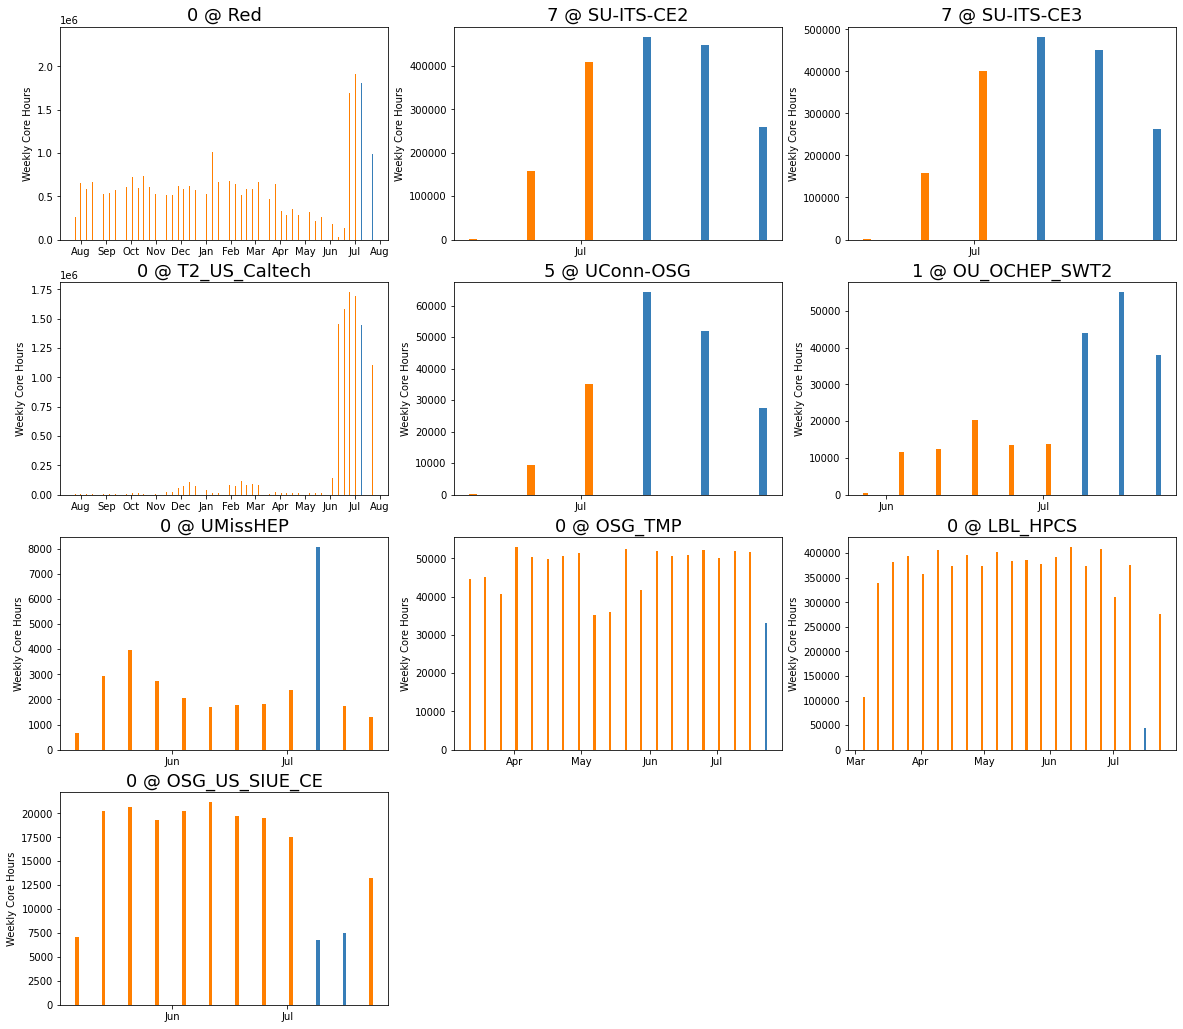

10


In [65]:
from sklearn.ensemble import IsolationForest  # Need to learn what Isolation Forest does

test_days = 3
plot_num = 1
num_outliers = 0
new_array = []
plt.figure(figsize=(20, 140))
# print(len(probes))
for interested_probe in probes:
  # Enumerate the VONames
  voname_map = {}
  for record in probes[interested_probe]:   # What is a record?
    if record[1] not in voname_map:
      #print(record[1])   #I'm unsure what this is doing, because it is just printing out a bunch of numbers
      new_id = len(voname_map)
      voname_map[record[1]] = new_id
    record[1] = voname_map[record[1]]

  
  new_array = []
  #print(interested_probe)
  num_days = len(probes[interested_probe])
  
  # Make sure there's enough days to test
  if num_days < (test_days*3):
    continue
    
  # Make sure the last days are within a few days of now
  last_day = datetime.datetime.fromtimestamp(probes[interested_probe][-1][0]/1000)
  if last_day < (end_time - datetime.timedelta(days=test_days*2)):
    continue
  
  # Only use the columns 1 and 2  ### ***What is column 1 and 2?***
  new_array = np.array(probes[interested_probe])
  
  #print(probes[interested_probe])   # What are these values supposed to represent?
  #for z in probes[interested_probe]:
  #  new_array.append([z[2], z[2]])
  #date_array = np.array(probes[interested_probe])
  date_array = new_array
  
  
  def convert_datetime(array):
    #print(array[0])
    return np.array([datetime.datetime.fromtimestamp(array[0]/1000), array[1], array[2]])
  
  date_array = np.apply_along_axis(convert_datetime, 1, date_array)
  #print(new_array[:88])
  
  np_array = []
  test_array = []
  # Split the data into test and train
  for row in date_array:
    if row[0] < (datetime.datetime.now() - datetime.timedelta(days=test_days*7)):  
      np_array.append(row)
    else:
      test_array.append(row)  
  np_array = np.array(np_array)
  test_array = np.array(test_array)
  
  #np_array = np.array(new_array[:num_days-test_days])
  #print(np_array)
  #test_array = np.array(new_array[-test_days:])
  #print(np_array)
  outliers_fraction = .01  # Percentage of observations we believe to be outliers
  #print("Testing against array of size:", np_array.shape)
  iso_forest = IsolationForest(contamination=outliers_fraction, random_state=42)
  try:
    y_pred = iso_forest.fit(np_array[:][:,[1,2]]).predict(test_array[:][:,[1,2]])
  except:
    print("Failed array:", np_array)
    continue
  colors = np.array(['#377eb8', '#ff7f00'])
  #print(y_pred)
  outlier = False
  inverted_voname_map = dict([[v,k] for k,v in voname_map.items()])
  outlier_vos = []
  for idx, pred in enumerate(y_pred):
    if pred == -1:
      #print(inverted_voname_map)
      #print(voname_map)
      outlier_vo = test_array[idx][1]
      #print("Outlier:", interested_probe, "VOName:", outlier_vo)
      outlier_vos.append(outlier_vo)
      outlier = True
  
  outlier_vos = set(outlier_vos) #I'm unsure of what the set function does
  # Add the "outlier" column to the arrays
  np_array = np.append(np_array, np.ones([len(np_array),1], dtype=np.int8),1)
  test_array = np.append(test_array, y_pred[...,None], 1)
  total_array = np.concatenate((np_array, test_array))
  
  for outlier_vo in outlier_vos:

    to_graph = []
    # Create the graphing array
    for row in total_array:
      if int(row[1]) != outlier_vo:
        #print(row[1], outlier_vo)
        continue
      to_graph.append(row)
        

    to_graph = np.array(to_graph)
    #print(to_graph.shape)
    ax_now = plt.subplot(30, 3, plot_num)
    #print(to_graph[:, 2])

    #new_plt = ax_now.scatter(date_array[:, 0].astype("datetime64[ns]"), date_array[:, 2])# , s=10, color=colors[(to_graph[:, 3].astype(int) + 1) // 2])
    new_plt = ax_now.bar(to_graph[:, 0].astype("datetime64[ns]"), to_graph[:, 2], width=0.99, color=colors[(to_graph[:, 3].astype(int) + 1) // 2]) # width=3
    plt.title("{} @ {}".format(inverted_voname_map[int(outlier_vo)], interested_probe), size=18)
    #ax_now.text(.99, .01, "Outlier",
    #               transform=plt.gca().transAxes, size=15,
    #               horizontalalignment='right')
    months = mdates.MonthLocator()  # every month
    monthsFmt = mdates.DateFormatter('%b')
    ax_now.xaxis.set_major_locator(months)
    ax_now.xaxis.set_major_formatter(monthsFmt)
    plt.ylabel("Weekly Core Hours")

    plot_num += 1
    num_outliers += 1
      

    

plt.show()
print(num_outliers)
  